# Example Notebook for none-regressive TCN-TCN model

In [ ]:
from tcn_sequence_models.data_processing.preprocessor import Preprocessor
from tcn_sequence_models.models import TCN_TCN_Normal
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import os
from tcn_sequence_models.utils.scaling import inverse_scale_sequences
import numpy as np

In [2]:
#set config_path to a path on your system. There, the model and preprocessor configs
# will be saved to.
config_path = "./config_TCN_TCN_normal"
os.makedirs(name=config_path, exist_ok=True)

## Load and process data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
df = pd.read_csv(url)

In [4]:
time_col = 'DateTime'
df[time_col]= pd.to_datetime(df[time_col])

In [5]:
# Define features to use
features_input_encoder = [
    "Temperature",
    "Humidity",
    "Wind Speed",
    "general diffuse flows",
    "diffuse flows"
]

features_input_decoder = [
]

feature_target = "Zone 1 Power Consumption"

In [6]:
# Add temporal encodings. Possible are: 'seasons', 'months', 'weekdays' and 'hours'
temporal_encoding_modes = ["weekdays", "hours"]

In [7]:
split_ratio = 0.7
input_seq_len = 200
output_seq_len = 50
# Here use the none-regressive model. If you want to use the auto-regressive model
# with teacher-forcing, set it to True
autoregressive = False

In [8]:
preprocessor = Preprocessor(df)

In [9]:
# split_date = datetime.date(2019, 1, 1)
preprocessor.process(
    features_input_encoder,
    features_input_decoder,
    feature_target,
    input_seq_len,
    output_seq_len,
    model_type="tcn_tcn",
    time_col=time_col,
    split_ratio = split_ratio,
    split_date = None,
    temporal_encoding_modes=temporal_encoding_modes,
    autoregressive=autoregressive,
    )

In [10]:
X_train, y_train, X_val, y_val = preprocessor.train_test_split(split_ratio)

## Create model and fit it

In [29]:
from tensorflow.keras.optimizers import Adam

model = TCN_TCN_Normal()

model.build(
    num_layers_tcn = None,
    num_filters = 4,
    kernel_size = 3,
    dilation_base = 2,
    dropout_rate = 0.2,
    neurons_output = [16],
    activation = "relu",
    kernel_initializer = "he_normal",
    batch_norm_tcn = True,
    layer_norm_tcn = False,
    autoregressive=autoregressive,
    padding_decoder='same')
model.compile(optimizer=Adam(learning_rate=0.003, decay=1e-3))


In [30]:
cb_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=10,
          batch_size=64,
          callbacks = cb_early_stopping
          )

Epoch 1/10
568/568 [==============================] - 27s 35ms/step - loss: 0.8572 - val_loss: 0.2802
Epoch 2/10
568/568 [==============================] - 19s 33ms/step - loss: 0.2520 - val_loss: 0.2413
Epoch 3/10
568/568 [==============================] - 19s 34ms/step - loss: 0.2063 - val_loss: 0.2369
Epoch 4/10
568/568 [==============================] - 19s 34ms/step - loss: 0.1864 - val_loss: 0.2196
Epoch 5/10
568/568 [==============================] - 19s 33ms/step - loss: 0.1737 - val_loss: 0.1986
Epoch 6/10
568/568 [==============================] - 19s 33ms/step - loss: 0.1652 - val_loss: 0.2107
Epoch 7/10
568/568 [==============================] - 20s 35ms/step - loss: 0.1581 - val_loss: 0.2145
Epoch 8/10
568/568 [==============================] - 19s 34ms/step - loss: 0.1526 - val_loss: 0.2078


## Make predictions

In [13]:
y_pred = model.predict(X_val)

In [14]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor.scaler_y)
y_val_unscaled = inverse_scale_sequences(np.expand_dims(y_val, axis=-1),
                                                        preprocessor.scaler_y)

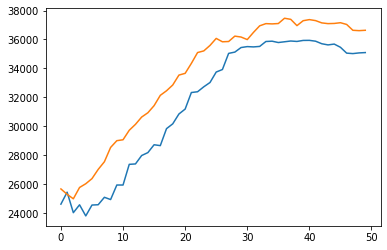

In [15]:
plt.plot(y_pred_unscaled[4000])
plt.plot(y_val_unscaled[4000])
plt.show()

## Save the preprocessor and the model

In [16]:
preprocessor.save_preprocessor_config(save_path=config_path)

In [17]:
model.save_model(config_path)

## Load the saved preprocessor and model

In [18]:
preprocessor_loaded = Preprocessor(df)
preprocessor_loaded.load_preprocessor_config(load_path=config_path)

In [19]:
# Load with the intention to only use the model for inference. If the model shall be
# trained, use process_from_config_training() and the get the training data with the
# train_test_split() method.
preprocessor_loaded.process_from_config_inference()

In [20]:
model_loaded = TCN_TCN_Normal()

In [21]:
model_loaded.load_model(config_path, preprocessor_loaded.X, is_training_data=False)
# If you use the autoregressive model:
# model_loaded.load_model(config_path, X_init[:3],
# is_training_data=True)

In [22]:
y_pred = model_loaded.predict(preprocessor_loaded.X)

In [23]:
y_pred_unscaled = inverse_scale_sequences(y_pred, preprocessor_loaded.scaler_y)
y_true_unscaled = inverse_scale_sequences(np.expand_dims(preprocessor.y, axis=-1),
                                                        preprocessor_loaded.scaler_y)

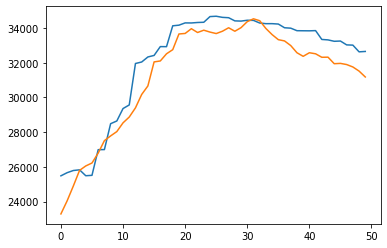

In [24]:
plt.plot(y_pred_unscaled[1000])
plt.plot(y_true_unscaled[1000])
plt.show()

## Run bayessian optimizer to find the optimal hyperparameters

In [28]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "./search_3",
        patience=3,
        loss = "mse",
        max_trials = 10,
        executions_per_trial = 1,
        num_filters = [4, 6, 8],
        neurons_output = [16],
        kernel_size = [5, 9, 13, 17],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2, 0.3],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        batch_norm_tcn = [False],
        layer_norm_tcn = [True],
        padding_decoder = ['same', 'causal']
    )


Trial 1 Complete [00h 01m 27s]
val_loss: 0.2063804268836975

Best val_loss So Far: 0.2063804268836975
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit
